### Saesonal-ARIMA zur Schätzung von monatlichen Temperaturdaten

#### 1) Daten laden

In [1]:
import pandas as pd
from math import ceil

pd.set_option('display.max_columns', 6)

data_url=r'https://github.com/tplusone/hanser_ml_zeitreihen/blob/master/Daten/jena_climate_temp_monthly.csv?raw=true'
df = pd.read_csv(data_url)
df['Date Time'] = pd.to_datetime(df['Date Time'])
df = df.set_index('Date Time')
df.index.freq = 'M'
df.head()

,T (degC)
Date Time,
2009-01-31,3.901250
2009-02-28,4.358247
2009-03-31,5.665444
2009-04-30,10.372165
2009-05-31,12.690187


#### 2) Saisonale Bereinigung für Voranalysen durchführen

In [2]:
import numpy as np

var='T (degC)'
df['T log'] = np.log(df[var])
df['T_season_diff'] = df['T log'].diff(periods=12)
means = df.groupby(df.index.month)[['T log']].mean()
means.columns = ['T_month']
df = df.merge(means, left_on=df.index.month, right_index=True, how='left')
df['T_month_cleaned'] = df['T log'] - df['T_month']    
df['T_month_cleaned_diff'] = df['T_month_cleaned'].diff()
df.head()

C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,T (degC),T log,T_season_diff,T_month,T_month_cleaned,T_month_cleaned_diff
Date Time,,,,,,
2009-01-31,3.901250,1.361297,NaN,1.297906,0.063391,NaN
2009-02-28,4.358247,1.472070,NaN,1.430387,0.041683,-0.021709
2009-03-31,5.665444,1.734385,NaN,1.798251,-0.063865,-0.105548
2009-04-30,10.372165,2.339126,NaN,2.340883,-0.001757,0.062109
2009-05-31,12.690187,2.540829,NaN,2.502161,0.038668,0.040425


#### 3) Autokorrelationsdiagramme

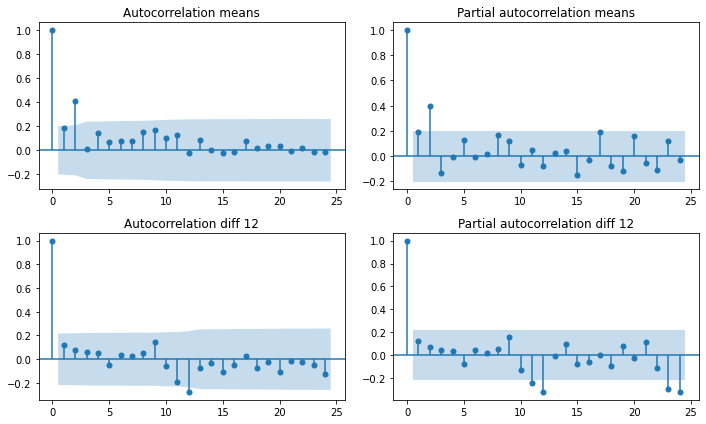

In [3]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2,2,3)
fig = plot_acf(df['T_season_diff'].dropna(), lags=24, ax=ax1, title=None)    
ax2 = fig.add_subplot(224)
fig = plot_pacf(df['T_season_diff'].dropna(), lags=24, ax=ax2, title=None)
ax3 = fig.add_subplot(221)
fig = plot_acf(df['T_month_cleaned'].dropna(), lags=24, ax=ax3, title=None)
ax4 = fig.add_subplot(222)
fig = plot_pacf(df['T_month_cleaned'].dropna(), lags=24, ax=ax4, title=None)
ax1.set_title('Autocorrelation diff 12')
ax2.set_title('Partial autocorrelation diff 12')
ax3.set_title('Autocorrelation means')
ax4.set_title('Partial autocorrelation means')
plt.tight_layout()

#### 4) Train-/Test-Split

In [4]:
train_size = .8
split_idx = ceil(len(df)*train_size)
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]
len(df_train), len(df_test)

(77, 19)

#### 5) Seasonal ARIMA-Modell anlernen

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

result = SARIMAX(df_train['T log'], order=([0,1],0,0), 
                  seasonal_order=(0,1,1,12)).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  T log   No. Observations:                   77
Model:             SARIMAX([2], 0, 0)x(0, 1, [1], 12)   Log Likelihood                 -29.780
Date:                                Mon, 31 Aug 2020   AIC                             65.560
Time:                                        10:45:40   BIC                             72.083
Sample:                                    01-31-2009   HQIC                            68.133
                                         - 05-31-2015                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.3716      0.118      3.156      0.002       0.141       0.602
ma.S.L12      -0.6609      0.165     -4.013      0.000      -0.984      -0.338
sigma2         0.1324      0.023      5.837      0.000       0.088       0.177
===================================================================================
Ljung-Box (Q):                       40.58   Jarque-Bera (JB):                23.82
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.55
Prob(H) (two-sided):                  0.49   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 6) Modell mit der Brut Force-Methode anlernen
Im Vergleich zum Codeauszug im Text werden hier mit einem Try/Catch noch mögliche Fehler abgefangen. Die Fehler entstehen, wenn die SARIMAX-Klasse die zu testende Konfiguration nicht berechnen kann. 

In [6]:
def brut_force(data):
    cart = [ [i, j] for i in range(2) for j in range(2)]
    diff = list(range(2))
    orders = [ [ar, d, ma] for ar in cart for d in diff for ma in cart]
    seasonal_orders = [ [ar, d, ma, 12] for ar in cart for d in 
                        diff for ma in cart]
    results = []
    for order in orders:
        for seasonal_order in seasonal_orders:
            try:
                arima = SARIMAX(data, order=order, 
                           seasonal_order=seasonal_order)
                result = arima.fit()
                results.append( {'order':order, 
                             'seasonal_order': seasonal_order, 
                             'log likelihood': result.llf, 
                             'AIC': result.aic } )
            except:
                print('error')
               
    results.sort(key=lambda x : x['AIC'])
    return results

In [7]:
results = brut_force(df_train['T log'])

C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible 

error
error
error
error


C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error


C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likel

C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likel

error


C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likel

Anzeige der resultierenden Modelle

In [8]:
results[:5]

[{'order': [[0, 1], 0, [0, 0]],
  'seasonal_order': [[0, 0], 1, [1, 0], 12],
  'log likelihood': -29.779802659245824,
  'AIC': 65.55960531849165},
 {'order': [[0, 0], 0, [0, 1]],
  'seasonal_order': [[0, 0], 1, [1, 0], 12],
  'log likelihood': -30.28423237160608,
  'AIC': 66.56846474321216},
 {'order': [[0, 1], 0, [1, 0]],
  'seasonal_order': [[0, 0], 1, [1, 0], 12],
  'log likelihood': -29.42628428854472,
  'AIC': 66.85256857708944},
 {'order': [[0, 1], 0, [0, 0]],
  'seasonal_order': [[0, 0], 1, [1, 1], 12],
  'log likelihood': -29.43252711439799,
  'AIC': 66.86505422879597},
 {'order': [[0, 1], 0, [0, 0]],
  'seasonal_order': [[1, 0], 1, [1, 0], 12],
  'log likelihood': -29.470518524948883,
  'AIC': 66.94103704989777}]

#### 7) Vorhersagen anzeigen
Zuerst das Modell noch einmal anlernen:

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

result = SARIMAX(df_train['T log'], order=([0,1],0,0), 
                  seasonal_order=(0,1,1,12)).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  T log   No. Observations:                   77
Model:             SARIMAX([2], 0, 0)x(0, 1, [1], 12)   Log Likelihood                 -29.780
Date:                                Mon, 31 Aug 2020   AIC                             65.560
Time:                                        10:56:39   BIC                             72.083
Sample:                                    01-31-2009   HQIC                            68.133
                                         - 05-31-2015                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.3716      0.118      3.156      0.002       0.141       0.602
ma.S.L12      -0.6609      0.165     -4.013      0.000      -0.984      -0.338
sigma2         0.1324      0.023      5.837      0.000       0.088       0.177
===================================================================================
Ljung-Box (Q):                       40.58   Jarque-Bera (JB):                23.82
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.55
Prob(H) (two-sided):                  0.49   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

a) Predictions ohne Update über beliebigen Zeitraum erzeugen

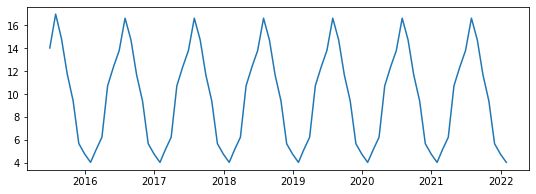

In [10]:
future = result.predict(start='2015-06', end='2022-01')
future = np.exp(future)   ### logarithmierung aufheben
plt.figure(figsize=(9, 3))
plt.plot(future)

b) Predictions ohne Update über Zeitraum der Testdaten erzeugen

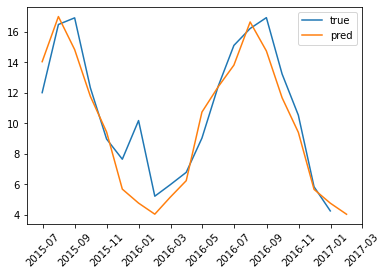

In [11]:
y_pred_no_update = result.predict(start='2015-06', end='2017-01')
y_pred_no_update = np.exp(y_pred_no_update)   ### logarithmierung aufheben
plt.xticks(rotation=45)
plt.plot(df_test['T (degC)'], label='true')
plt.plot(y_pred_no_update, label='pred')
plt.legend()

c) Predictions mit Update über Zeitraum der Testsdaten erzeugen

C:\Users\jhjav\Anaconda3\envs\ml_time\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


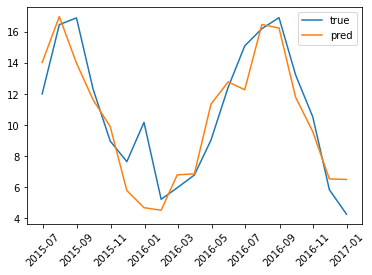

In [12]:
def predict_with_update(model_result, df_test, col):
    y_pred = pd.Series()
    y_true = df_test[col]
    for i in range(len(y_true)):
        y_temp = model_result.forecast()
        y_pred = y_pred.append(y_temp)
        update = y_true[y_temp.index]
        model_result = model_result.extend(update)
    return y_pred

y_pred_update = predict_with_update(result, df_test, 'T log' )
y_pred_update = np.exp(y_pred_update)   ### logarithmierung aufheben
plt.xticks(rotation=45)
plt.plot(df_test['T (degC)'], label='true')
plt.plot(y_pred_update, label='pred')
plt.legend()